## Применение RandomForest на реальной задаче (предсказание оттока клиентов)

Семинар основан на <a href="https://habr.com/en/company/ods/blog/324402/">материале</a> ODS

In [1]:
import warnings
warnings.simplefilter("ignore")

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

from IPython.display import Image
from matplotlib import pyplot as plt

from sklearn.ensemble import BaggingRegressor, BaggingClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

from sklearn.metrics import accuracy_score
from sklearn.datasets import load_digits as load
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV, train_test_split

%matplotlib inline

/Users/maxim/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


----------

Далее рассмотрим несколько параметров, на которые в первую очередь стоит обратить внимание при построении модели:
- n_estimators — число деревьев в "лесу"
- criterion — критерий для разбиения выборки в вершине
- max_features — число признаков, по которым ищется разбиение
- min_samples_leaf — минимальное число объектов в листе
- max_depth — максимальная глубина дерева

Данные можно взять тут: https://github.com/Yorko/mlcourse_open/blob/master/data/telecom_churn.csv

In [3]:
#!wget https://raw.githubusercontent.com/Yorko/mlcourse.ai/master/data/telecom_churn.csv -O data/telecom_churn.csv

Будем использовать пример с задачей fraud detection. Это задача классификации, поэтому будем использовать метрику accuracy для оценки точности. Для начала построим самый простой классификатор, который будет нашим бейслайном. Возьмем только числовые признаки для упрощения.

In [4]:
# Загружаем данные
df = pd.read_csv("data/telecom_churn.csv")

# Выбираем сначала только колонки с числовым типом данных
cols = []
for i in df.columns:
    if (df[i].dtype == "float64") or (df[i].dtype == 'int64'):
        cols.append(i)
        
# Разделяем на признаки и объекты
X, y = df[cols].copy(), np.asarray(df["Churn"],dtype='int8')

# Инициализируем стратифицированную разбивку нашего датасета для валидации
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Инициализируем наш классификатор с дефолтными параметрами
rfc = RandomForestClassifier(random_state=42, n_jobs=-1, oob_score=True)

# Обучаем на тренировочном датасете
results = cross_val_score(rfc, X, y, cv=skf)

# Оцениваем точность на тестовом датасете
print("CV accuracy score: {:.2f}%".format(results.mean()*100))

/Users/maxim/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/maxim/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/maxim/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/maxim/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates

CV accuracy score: 91.48%


/Users/maxim/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


Попробуем улучшить этот результат и посмотреть, как ведут себя кривые обучения при изменении основных параметров.

Начнем с количества деревьев:

In [5]:
# Инициализируем валидацию
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Создаем списки для сохранения точности на тренировочном и тестовом датасете
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
trees_grid = [5, 10, 15, 20, 30, 50, 75, 100]

# Обучаем на тренировочном датасете
for ntrees in trees_grid:
    rfc = RandomForestClassifier(n_estimators=ntrees, random_state=42, n_jobs=-1, oob_score=True)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)
    
train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} trees".format(max(test_acc.mean(axis=1))*100, 
                                                        trees_grid[np.argmax(test_acc.mean(axis=1))]))

/Users/maxim/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/maxim/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/maxim/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/maxim/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates

Best accuracy on CV is 92.44% with 50 trees


In [6]:
plt.style.use('ggplot')

In [7]:
def plot_acc_for_grid(train_acc, test_acc, param_grid, param_name="n_estimators"):
    plt.figure(figsize=(12, 8))
    plt.plot(param_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
    plt.plot(param_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='cv')
    
    plt.fill_between(param_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
    plt.fill_between(param_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
    
    plt.legend(loc='best')
    plt.ylim([0.88,1.01])
    plt.ylabel("Accuracy")
    plt.xlabel(param_name)

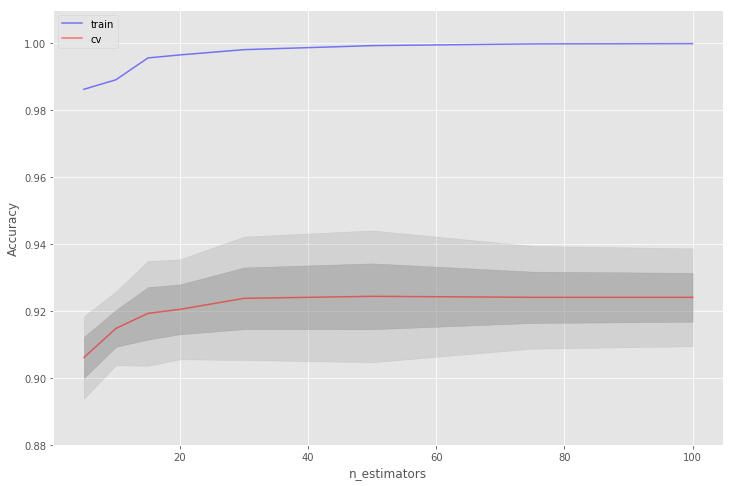

In [8]:
plot_acc_for_grid(train_acc, test_acc, trees_grid, param_name="n_estimators")

Как видно, при достижении определенного числа деревьев, наша точность на тесте выходит на асимптоту, и вы можете сами решить, сколько деревьев оптимально для вашей задачи. 
На рисунке также видно, что на тренировочной выборке мы смогли достичь 100% точности, это говорит нам о переобучении нашей модели. Чтобы избежать переобучения, мы должны добавить параметры регуляризации в модель.

Начнем с параметра максимальной глубины – `max_depth`. (зафиксируем к-во деревьев 100)

In [9]:
%%time
# Создаем списки для сохранения точности на тренировочном и тестовом датасете
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
max_depth_grid = [3, 5, 7, 9, 11, 13, 15, 17, 20, 22, 24]

# Обучаем на тренировочном датасете
for max_depth in max_depth_grid:
    rfc = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, oob_score=True, max_depth=max_depth)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)
    
train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} max_depth".format(max(test_acc.mean(axis=1))*100, max_depth_grid[np.argmax(test_acc.mean(axis=1))]))

Best accuracy on CV is 92.68% with 17 max_depth
CPU times: user 46.7 s, sys: 2.68 s, total: 49.4 s
Wall time: 34.2 s


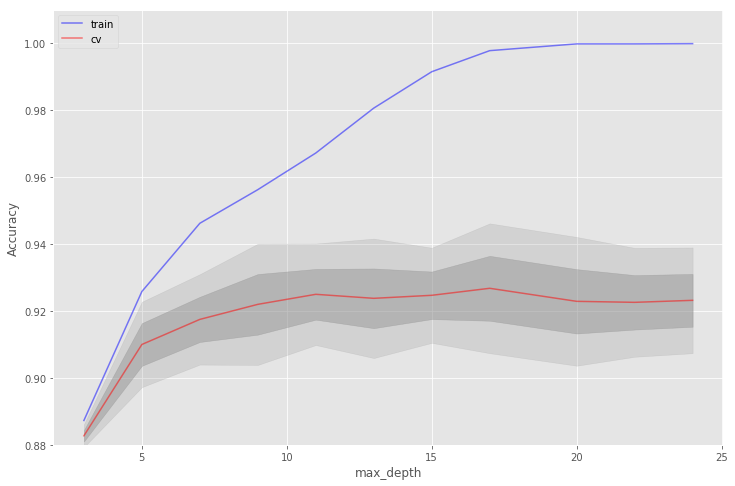

In [10]:
plot_acc_for_grid(train_acc, test_acc, max_depth_grid, param_name="max_depth")

Параметр `max_depth` хорошо справляется с регуляризацией модели, и мы уже не так сильно переобучаемся. Точность нашей модели немного возросла.

Еще важный параметр `min_samples_leaf`, он так же выполняет функцию регуляризатора.


In [11]:
%%time
# Создаем списки для сохранения точности на тренировочном и тестовом датасете
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
min_samples_leaf_grid = [1, 3, 5, 7, 9, 11, 13, 15, 17, 20, 22, 24]

# Обучаем на тренировочном датасете
for min_samples_leaf in min_samples_leaf_grid:
    rfc = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, 
                                 oob_score=True, min_samples_leaf=min_samples_leaf)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)
    
train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} min_samples_leaf".format(max(test_acc.mean(axis=1))*100, 
                                                        min_samples_leaf_grid[np.argmax(test_acc.mean(axis=1))]))

Best accuracy on CV is 92.41% with 3 min_samples_leaf
CPU times: user 49.9 s, sys: 2.81 s, total: 52.7 s
Wall time: 35.3 s


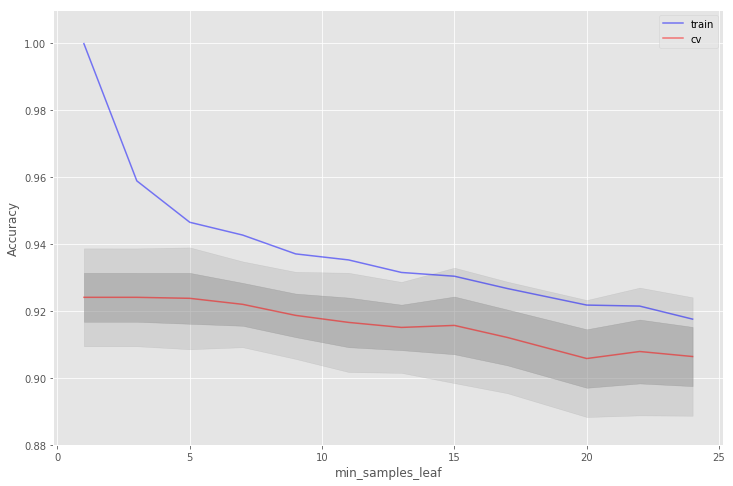

In [12]:
plot_acc_for_grid(train_acc, test_acc, min_samples_leaf_grid, param_name="min_samples_leaf")

В данном случае мы не выигрываем в точности на валидации, но зато можем сильно уменьшить переобучение до 2% при сохранении точности около 92%.

Рассмотрим такой параметр как `max_features`. Для задач классификации по умолчанию используется $\large \sqrt{n}$, где n — число признаков. Давайте проверим, оптимально ли в нашем случае использовать 4 признака или нет.


In [13]:
%%time
# Создаем списки для сохранения точности на тренировочном и тестовом датасете
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
max_features_grid = [2, 4, 6, 8, 10, 12, 14, 16]

# Обучаем на тренировочном датасете
for max_features in max_features_grid:
    rfc = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, 
                                 oob_score=True, max_features=max_features)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)
    
train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} max_features".format(max(test_acc.mean(axis=1))*100, max_features_grid[np.argmax(test_acc.mean(axis=1))]))

Best accuracy on CV is 92.59% with 12 max_features
CPU times: user 1min 10s, sys: 1.86 s, total: 1min 12s
Wall time: 37.7 s


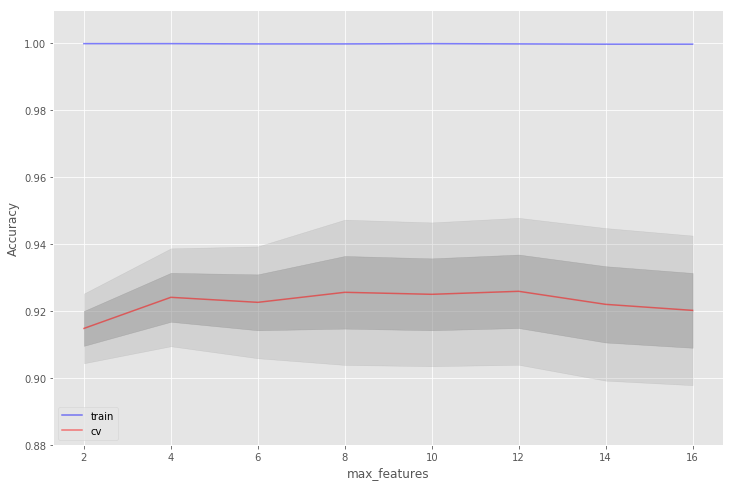

In [14]:
plot_acc_for_grid(train_acc, test_acc, max_features_grid, param_name="max_features")

В нашем случае оптимальное число признаков — 10, именно с таким значением достигается наилучший результат.

Мы рассмотрели, как ведут себя кривые обучения в зависимости от изменения основных параметров. Давайте теперь с помощью `GridSearch` найдем оптимальные параметры для нашего примера.


<center><img src="img/first_kaggle.jpg" width=700></center>

In [15]:
%%time
# Сделаем инициализацию параметров, по которым хотим сделать полный перебор
rfc = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, oob_score=True)
param_grid = {
    'max_features': [4, 7, 10, 13], 
    'min_samples_leaf': [1, 3, 5, 7], 
    'max_depth': [5,10,15,20],
}
gcv = GridSearchCV(rfc, param_grid, n_jobs=-1, cv=skf, verbose=1)
gcv.fit(X, y)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:  2.7min finished


CPU times: user 2.69 s, sys: 249 ms, total: 2.94 s
Wall time: 2min 43s


In [16]:
gcv.best_estimator_, gcv.best_score_

(RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=10, max_features=10, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
             oob_score=True, random_state=42, verbose=0, warm_start=False),
 0.9270927092709271)

<h1 align="center">Выводы</h1> 

**Bagging**:
    - Одна из лучших техник для построения алгоритмов ML
    - Линейно уменьшает разброс и не уменьшает смещение (если не коррелированы ответы базовых алоритмов) 
    - Слабое переобучение
    - НО переобучение ЕСТЬ -- от сложности одного алгоритма, лучше все же немного обрезать деревья

** Random Forest **

Плюсы:
- имеет высокую точность предсказания, на большинстве задач будет лучше линейных алгоритмов; точность сравнима с точностью бустинга
- практически не чувствителен к выбросам в данных из-за случайного сэмлирования
- не чувствителен к масштабированию (и вообще к любым монотонным преобразованиям) значений признаков, связано с выбором случайных подпространств
- не требует тщательной настройки параметров, хорошо работает «из коробки». С помощью «тюнинга» параметров можно достичь прироста от 0.5 до 3% точности в зависимости от задачи и данных
- способен эффективно обрабатывать данные с большим числом признаков и классов
- одинаково хорошо обрабатывет как непрерывные, так и дискретные признаки
- редко переобучается, на практике добавление деревьев почти всегда только улучшает композицию, но на валидации, после достижения определенного количества деревьев, кривая обучения выходит на асимптоту
- для случайного леса существуют методы оценивания значимости отдельных признаков в модели
- хорошо работает с пропущенными данными; сохраняет хорошую точность, если большая часть данных пропущенна
- предполагает возможность сбалансировать вес каждого класса на всей выборке, либо на подвыборке каждого дерева
- вычисляет близость между парами объектов, которые могут использоваться при кластеризации, обнаружении выбросов или (путем масштабирования) дают интересные представления данных
- возможности, описанные выше, могут быть расширены до неразмеченных данных, что приводит к возможности делать кластеризацию и визуализацию данных, обнаруживать выбросы
- высокая параллелизуемость и масштабируемость.

Минусы:
- в отличие от одного дерева, результаты случайного леса сложнее интерпретировать
- нет формальных выводов (p-values), доступных для оценки важности переменных
- алгоритм работает хуже многих линейных методов, когда в выборке очень много разреженных признаков (тексты, Bag of words)
- случайный лес не умеет экстраполировать, в отличие от той же линейной регрессии (но это можно считать и плюсом, так как не будет экстремальных значений в случае попадания выброса)
- алгоритм склонен к переобучению на некоторых задачах, особенно на зашумленных данных
- для данных, включающих категориальные переменные с различным количеством уровней, случайные леса предвзяты в пользу признаков с большим количеством уровней: когда у признака много уровней, дерево будет сильнее подстраиваться именно под эти признаки, так как на них можно получить более высокое значение оптимизируемого функционала (типа прироста информации)
- если данные содержат группы коррелированных признаков, имеющих схожую значимость для меток, то предпочтение отдается небольшим группам перед большими
- больший размер получающихся моделей. Требуется $O(NK)$ памяти для хранения модели, где $K$ — число деревьев.